# VCF

In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
from pybedtools import BedTool
import pybedtools
import pandas as pd
import numpy as np
import dask.dataframe as dd
import warnings
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
from pybedtools import BedTool
import pybedtools
import pandas as pd
import numpy as np
import dask.dataframe as dd
import warnings
from pathlib import Path

warnings.filterwarnings("ignore")
df_centro = pd.read_table("chm13v2.0_censat_v2.0.bed", 
                          usecols=range(4), 
                          skiprows=1, 
                          header=None, 
                          names=["seqID", "start", "end", "compartment"]
                         )
df_centro.loc[:, "compartment"] = df_centro["compartment"].str.split("_", expand=True)[0]

chrSizes = pd.read_table("genome_chromosome_sizess.txt")

chrSizes = chrSizes[chrSizes["organism"] == "chm13v2.0"].drop(columns=["organism"])\
                .rename(columns={"length": "chrLen"})

df_centro = df_centro.merge(chrSizes, how="left", on="seqID")
df_centro

,seqID,start,end,compartment,chrLen
0,chr1,116796047,121405145,ct,248387328
1,chr1,121405145,121406286,censat,248387328
2,chr1,121406286,121619169,ct,248387328
3,chr1,121619169,121625213,hor,248387328
4,chr1,121625213,121667941,hor,248387328
...,...,...,...,...,...
2518,chrY,62025776,62037362,censat,62460029
2519,chrY,62052955,62059882,censat,62460029
2520,chrY,62061431,62072743,hsat3,62460029
2521,chrY,62072743,62087298,bsat,62460029


In [42]:
chromosomes =  {
                1: 'NC_060925.1',
                2: 'NC_060926.1',	
                3: 'NC_060927.1',
                4: 'NC_060928.1',
                5: 'NC_060929.1',
                6: 'NC_060930.1',
                7: 'NC_060931.1',
                8: 'NC_060932.1',
                9: 'NC_060933.1',	
                10: 'NC_060934.1',	
                11: 'NC_060935.1',	
                12: 'NC_060936.1',		
                13: 'NC_060937.1',	
                14: 'NC_060938.1',
                15: 'NC_060939.1',		
                16: 'NC_060940.1',		
                17: 'NC_060941.1',	
                18: 'NC_060942.1',	
                19: 'NC_060943.1',	
                20: 'NC_060944.1',	
                21: 'NC_060945.1',	
                22: 'NC_060946.1',	
                'X': 'NC_060947.1',
                'Y': 'NC_060948.1'
}
chromosomes = {v: f'chr{k}' for k, v in chromosomes.items()}

human_gff = pd.read_table(
                          "GCF_009914755.1_T2T-CHM13v2.0_genomic.gff.gz",
                          comment="#",
                          header=None,
                          names=["seqID", 
                                 "source", 
                                 "compartment", 
                                 "start", 
                                 "end", 
                                 "score", 
                                 "strand", 
                                 "phase", 
                                 "attributes"],
                        )

human_gff = human_gff[human_gff["compartment"].isin({"gene", "silencer", "CDS", "exon", "enhancer", "region"})].reset_index(drop=True)
human_gff = human_gff[["seqID", "start", "end", "compartment"]]
human_gff.loc[:, "start"] = human_gff["start"] - 1
human_gff.loc[:, "seqID"] = human_gff["seqID"].apply(lambda y: chromosomes[y])
human_gff

,seqID,start,end,compartment
0,chr1,0,248387328,region
1,chr1,7505,138480,gene
2,chr1,138320,138480,exon
3,chr1,129905,130010,exon
4,chr1,109650,109660,exon
...,...,...,...,...
3985072,chrY,62448757,62448826,CDS
3985073,chrY,62448966,62449100,CDS
3985074,chrY,62451556,62451910,exon
3985075,chrY,62451062,62451171,exon


In [43]:
from tqdm import tqdm
compartments = ["region", "gene", "silencer", "CDS", "exon", "enhancer"]

merged_gff = []
for compartment in tqdm(compartments):
    limited_gff = BedTool.from_dataframe(human_gff[human_gff["compartment"] == compartment])\
                                .sort()\
                                .merge(c=["4", "4"], 
                                       o=["count", "distinct"])
    
    limited_gff = pd.read_table(limited_gff.fn, 
                                header=None, 
                                names=["seqID", "start", "end", "totalCompartments", "compartment"]
                               )
    # limited_gff.loc[:, "compartment"] = compartment
    merged_gff.append(limited_gff)

merged_gff = pd.concat(merged_gff, axis=0)
merged_gff["compartment"] = merged_gff["compartment"].apply(lambda x: x.capitalize() if x != "CDS" else x)\
                                                .replace("Region", "Genome")
merged_gff

df_compartments = pd.concat([merged_gff, 
                             df_centro
                            ], 
                            axis=0).drop(columns=['totalCompartments', 'chrLen'])

df_compartments

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:07<00:00,  1.29s/it]


,seqID,start,end,compartment
0,chr1,0,248387328,Genome
1,chr10,0,134758134,Genome
2,chr11,0,135127769,Genome
3,chr12,0,133324548,Genome
4,chr13,0,113566686,Genome
...,...,...,...,...
2518,chrY,62025776,62037362,censat
2519,chrY,62052955,62059882,censat
2520,chrY,62061431,62072743,hsat3
2521,chrY,62072743,62087298,bsat


In [2]:
df_vcf = pd.read_table("hprc-v1.1-mc-chm13.vcfbub.a100k.wave.vcf", 
                       nrows=100_000, 
                       comment="#", 
                       usecols=[0, 1, 3, 4, 5], 
                       header=None,
                       names=["seqID", "start", "allele", "variant", "count"]
                      )

def classify_variant(trans):
    allele, variant = trans.split(">")
    
    allele_N = len(allele)
    variant_N = len(variant)
    
    if allele_N < variant_N:
        return "ins"

    if allele_N > variant_N:
        return "del"

    if allele_N == variant_N and allele_N == 1:
        return "snp"

    return "mnp"
        
df_vcf.loc[:, "transition"] = df_vcf["allele"] + ">" + df_vcf["variant"]
df_vcf.loc[:, "type"] = df_vcf["transition"].apply(classify_variant)
df_vcf.loc[:, "end"] = df_vcf["start"]
df_vcf.loc[:, "start"] = df_vcf["start"] - 1
df_vcf

NameError: name 'pd' is not defined

In [4]:
from pwm_density import PWMExtractor
from make_windows import WindowMaker

In [5]:
window = WindowMaker()
window

WindowMaker(window_size=500, base=1)

In [6]:
df_vcf_windows = window.make_windows(df_vcf, loci="start")
df_vcf_windows

,seqID,start,end,allele,variant,count,transition,type
0,chr1,0,500,C,CCACCTAACCCTAACCCTACCTAACCCTAACCCTAACCCTAACCCT...,60,C>CCACCTAACCCTAACCCTACCTAACCCTAACCCTAACCCTAACC...,ins
1,chr1,0,500,CACCCTAAACCC,C,60,CACCCTAAACCC>C,del
2,chr1,0,500,CACCCTAAACCCTAACCCC,C,60,CACCCTAAACCCTAACCCC>C,del
3,chr1,0,500,CACCCTAAACCCTAACCCCTAACCCTAACCCTAACCCTAACCCTAA...,C,60,CACCCTAAACCCTAACCCCTAACCCTAACCCTAACCCTAACCCTAA...,del
4,chr1,0,505,T,TTCCCCCCCACCCCCACCCCCACCCCCACCCCCACCCCCTCCCCCA...,60,T>TTCCCCCCCACCCCCACCCCCACCCCCACCCCCACCCCCTCCCC...,ins
...,...,...,...,...,...,...,...,...
99995,chr1,5622343,5623344,C,T,60,C>T,snp
99996,chr1,5622404,5623405,T,C,60,T>C,snp
99997,chr1,5622419,5623420,T,C,60,T>C,snp
99998,chr1,5622556,5623557,T,C,60,T>C,snp


In [7]:
extractor = PWMExtractor(mode="other")
extractor

In [8]:
from tqdm import tqdm
model_organisms = [f for f in Path("pattern_maximal_abacaba").glob("*.maximal.txt") if "chm13" in f.name]
df_all = []

for species in tqdm(model_organisms):
    df = pd.read_csv(species)
    df_all.append(df)
    
df_all = pd.concat(df_all, axis=0)
df_all

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:03<00:00,  6.92it/s]


,seqID,start,end,sequence,length,type
0,chr8,2692,2744,ctaactggtctctgaccttgattattaacggctgcaaccgggaaag...,52,abacaba
1,chr8,2721,2773,ggctgcaaccgggaaagattttattcaccgtcgatgcggccccgag...,52,abacaba
2,chr8,4032,4089,gcctcctgcaccacttaaagtcagagcgccagttattaatccccat...,57,abacaba
3,chr8,4624,4675,ctgacatttttattgcagtgaatgatgattggggcatcttaagaga...,51,abacaba
4,chr8,6142,6194,ttgatgttacttccaatcaaaagctaccatgcaattatttacataa...,52,abacaba
...,...,...,...,...,...,...
208289,chr11,135122238,135122288,gtctgtggccctgccatagaagcctgagttgatccacatgaaacca...,50,abacaba
208290,chr11,135122240,135122294,ctgtggccctgccatagaagcctgagttgatccacatgaaaccaac...,54,abacaba
208291,chr11,135122592,135122643,acagtgcctgggaagcacttggtaaatggcagctgtaattttgctc...,51,abacaba
208292,chr11,135122593,135122647,cagtgcctgggaagcacttggtaaatggcagctgtaattttgctct...,54,abacaba


In [44]:
centro_bed = BedTool.from_dataframe(df_compartments)
zimin_centro = BedTool.from_dataframe(df_all)

In [45]:
zimin_inter = pd.read_table(
                zimin_centro.intersect(centro_bed, wao=True).fn,
                header=None,
                names=list(df_all.columns) + list(df_centro.rename(columns={"seqID": "chrom", "start": "cStart", "end": "cEnd"}).columns) + ["overlap"],
)
zimin_inter

,seqID,start,end,sequence,length,type,chrom,cStart,cEnd,compartment,chrLen,overlap
0,chr8,2692,2744,ctaactggtctctgaccttgattattaacggctgcaaccgggaaag...,52,abacaba,chr8,0,146259331,Genome,52,NaN
1,chr8,2721,2773,ggctgcaaccgggaaagattttattcaccgtcgatgcggccccgag...,52,abacaba,chr8,0,146259331,Genome,52,NaN
2,chr8,4032,4089,gcctcctgcaccacttaaagtcagagcgccagttattaatccccat...,57,abacaba,chr8,0,146259331,Genome,57,NaN
3,chr8,4624,4675,ctgacatttttattgcagtgaatgatgattggggcatcttaagaga...,51,abacaba,chr8,0,146259331,Genome,51,NaN
4,chr8,6142,6194,ttgatgttacttccaatcaaaagctaccatgcaattatttacataa...,52,abacaba,chr8,5120,10485,Exon,52,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
8258550,chr11,135122592,135122643,acagtgcctgggaagcacttggtaaatggcagctgtaattttgctc...,51,abacaba,chr11,135120398,135124319,Gene,51,NaN
8258551,chr11,135122592,135122643,acagtgcctgggaagcacttggtaaatggcagctgtaattttgctc...,51,abacaba,chr11,0,135127769,Genome,51,NaN
8258552,chr11,135122593,135122647,cagtgcctgggaagcacttggtaaatggcagctgtaattttgctct...,54,abacaba,chr11,135120398,135124319,Gene,54,NaN
8258553,chr11,135122593,135122647,cagtgcctgggaagcacttggtaaatggcagctgtaattttgctct...,54,abacaba,chr11,0,135127769,Genome,54,NaN


In [47]:
zimin_inter.query("start == 121405103")

,seqID,start,end,sequence,length,type,chrom,cStart,cEnd,compartment,chrLen,overlap
1562584,chr1,121405103,121405155,aatcagaatgtgtcattctgatttaaactgcttattagttaatacc...,52,abacaba,chr1,121405011,121405306,Silencer,52,NaN
1562585,chr1,121405103,121405155,aatcagaatgtgtcattctgatttaaactgcttattagttaatacc...,52,abacaba,chr1,121404934,121406667,Exon,52,NaN
1562586,chr1,121405103,121405155,aatcagaatgtgtcattctgatttaaactgcttattagttaatacc...,52,abacaba,chr1,121405145,121406286,censat,10,NaN
1562587,chr1,121405103,121405155,aatcagaatgtgtcattctgatttaaactgcttattagttaatacc...,52,abacaba,chr1,121194338,121472492,Gene,52,NaN
1562588,chr1,121405103,121405155,aatcagaatgtgtcattctgatttaaactgcttattagttaatacc...,52,abacaba,chr1,116796047,121405145,ct,42,NaN
1562589,chr1,121405103,121405155,aatcagaatgtgtcattctgatttaaactgcttattagttaatacc...,52,abacaba,chr1,0,248387328,Genome,52,NaN


In [36]:
zimin_inter.groupby(["seqID", "start", "end"], as_index=False).agg(total=("length", "count")).query("total > 1")

,seqID,start,end,total
197728,chr1,121405103,121405155,2
198078,chr1,121667937,121667987,2
212657,chr1,126755729,126755780,2
212658,chr1,126755734,126755785,2
212721,chr1,126840423,126840482,2
...,...,...,...,...
4649153,chrY,59393743,59393807,2
4649842,chrY,60706661,60706723,2
4650148,chrY,61145501,61145552,2
4650342,chrY,61388914,61388976,2


In [35]:
zimin_inter[["seqID", "start", "end"]].duplicated().sum()

np.int64(243)

In [48]:
# wrong zimin_inter.compartment.value_counts(normalize=True)

In [49]:
bed_nomore = BedTool.from_dataframe(df_vcf_windows[["seqID", "start", "end", "type", "transition"]])
bed_zimin = BedTool.from_dataframe(zimin_inter)

In [10]:
intersect_df = pd.read_table(
                        bed_nomore.intersect(bed_zimin, wo=True).fn,
                        header=None,
                        names=["seqID", "start", "end", "type", "transition", "chrom", "motif_start", "motif_end", "sequence", "length", "typ", "overlap"]
)
intersect_df

,seqID,start,end,type,transition,chrom,motif_start,motif_end,sequence,length,typ,overlap
0,chr1,5024,6025,snp,C>A,chr1,6006,6066,ccagatgcaactgcccaatctcggacattccagctaccagtattgt...,60,abacaba,19
1,chr1,5026,6027,snp,T>A,chr1,6006,6066,ccagatgcaactgcccaatctcggacattccagctaccagtattgt...,60,abacaba,21
2,chr1,5026,6027,snp,T>A,chr1,6025,6077,ctcggacattccagctaccagtattgtgagccaaatgaatcttttt...,52,abacaba,2
3,chr1,5044,6045,snp,A>C,chr1,6006,6066,ccagatgcaactgcccaatctcggacattccagctaccagtattgt...,60,abacaba,39
4,chr1,5044,6045,snp,A>C,chr1,6025,6077,ctcggacattccagctaccagtattgtgagccaaatgaatcttttt...,52,abacaba,20
...,...,...,...,...,...,...,...,...,...,...,...,...
103478,chr1,5622162,5623163,del,AC>A,chr1,5622336,5622386,ggacaagatcctcagtgaggagggccggcgccagcaagccaagctg...,50,abacaba,50
103479,chr1,5622214,5623215,ins,A>AG,chr1,5622336,5622386,ggacaagatcctcagtgaggagggccggcgccagcaagccaagctg...,50,abacaba,50
103480,chr1,5622263,5623264,snp,G>A,chr1,5622336,5622386,ggacaagatcctcagtgaggagggccggcgccagcaagccaagctg...,50,abacaba,50
103481,chr1,5622342,5623343,snp,AC>CA,chr1,5622336,5622386,ggacaagatcctcagtgaggagggccggcgccagcaagccaagctg...,50,abacaba,44


In [11]:
# assert 1==0
intersect_df.loc[:, "strand"] = "+"

In [22]:
dels = intersect_df.query("type == 'del'")
ins = intersect_df.query("type == 'ins'")
snp = intersect_df.query("type == 'snp'")
dels.shape, ins.shape, snp.shape

((10856, 13), (14593, 13), (78034, 13))

In [23]:
density_dels = extractor.extract_density(dels, window_size=500)
density_ins = extractor.extract_density(ins, window_size=500)
density_snp = extractor.extract_density(snp, window_size=500)

densities = {
    "dels": density_dels,
    "ins": density_ins,
    "snp": density_snp
}

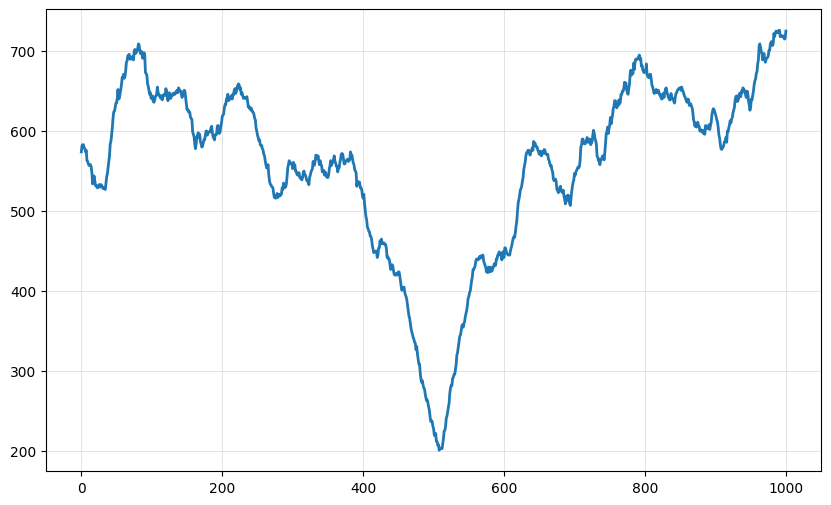

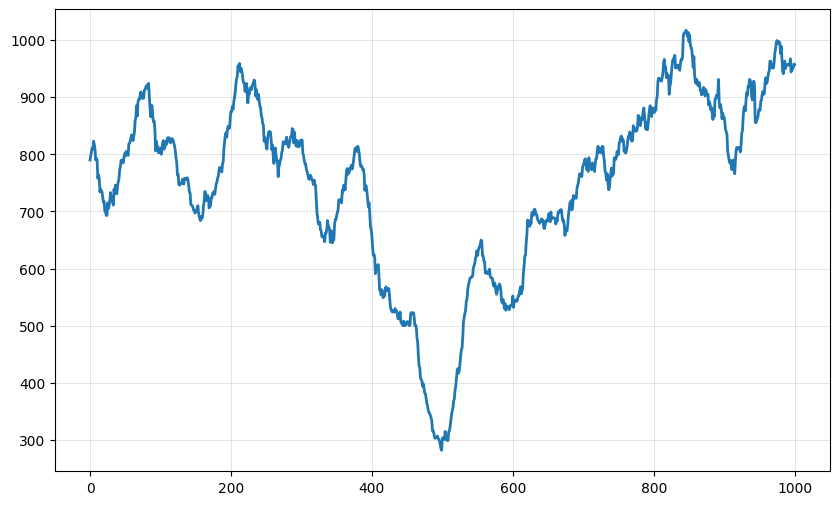

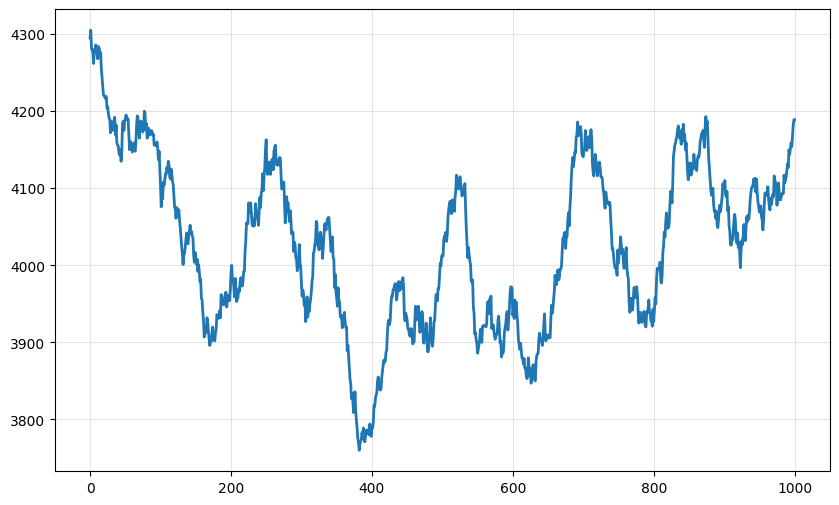

In [25]:
for typ, density in densities.items():
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
    ax.plot(range(len(density)), density, lw=2.0, zorder=3, label=typ)
    ax.grid(lw=0.4, alpha=0.6, zorder=0)
    plt.show()

In [ ]:
lifted_vcf = pd.read_table("hprc-v1.1-mc-chm13.vcfbub.a100k.wave.chrY.rebased_to_hhs1.vcf", 
                           header=None,
                           names=["seqID", "start", "end", "info"]
                          )
lifted_vcf

In [ ]:
lifted_vcf.head()

In [ ]:
seq[2465974:  	2465975]

In [ ]:
from Bio import SeqIO

def parse_fasta(f):
    for record in SeqIO.parse(f, 'fasta'):
        yield record.id, record.seq

In [ ]:
for seqID, seq in parse_fasta("chm13v2.0.fa"):
    print(seqID)
    if seqID == "chrY":
        print("FOUND IT!")
        break

In [ ]:
seq = seq.lower()

In [ ]:
seq[start-2: start+2]